In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import pandas as pd
import cmcrameri as cmcm
import juanfit

In [9]:
sumer_list_excel = pd.read_excel("../../save/sumer_line_list_final_v2.xlsx")
sumer_list_excel["ion"] = sumer_list_excel["ion"].str.strip()
sumer_list_excel["charge_stat"] = sumer_list_excel["charge_stat"].str.strip()
sumer_list_excel["quality"] = sumer_list_excel["quality"].str.strip()
sumer_list_excel

,ion,charge_stat,Z,A,temp,wvl_fit,wvl_chianti,fwhm_fit,fwhm_err,fwhm_true,fwhm_awsom,quality
0,Fe,xi,10,55.85000,6.0,680.439,680.406,0.3450,0.030,0.28048,0.172,b
1,Na,ix,8,22.98977,5.9,681.759,681.719,0.3080,0.005,0.23251,0.175,a
2,Mg,viii,7,24.31000,5.9,689.629,689.641,0.2760,0.020,0.18700,0.170,a
3,Ca,ix,8,40.08000,5.8,691.445,691.424,0.3280,0.020,0.25933,0.159,b
4,Si,ix,8,28.08550,5.9,694.738,694.686,0.2490,0.010,0.14180,0.185,a
5,Fe,viii,7,55.85000,5.8,697.155,697.156,0.2810,0.020,0.19474,0.154,a
6,Al,ix,8,26.98154,5.9,703.592,703.730,0.2560,0.086,0.15402,0.185,b
7,Mg,ix,8,24.31000,5.9,706.077,706.060,0.3050,0.003,0.22850,0.183,a
8,Ar,viii,7,39.94800,5.7,713.784,713.801,0.2830,0.010,0.19754,0.166,a
9,Mg,ix,8,24.31000,5.9,749.525,749.552,0.3010,0.009,0.22327,0.195,a


In [10]:
c = const.c.cgs/1.e5

In [11]:
def aver_err(data,err,thresh=1.e-5,iter_max=1000):
    sigma_sq = np.var(data)
    n_data = len(data)

    if type(data) is list:
        data = np.array(data)
    if type(err) is list:
        err = np.array(err)

    err_sq_mean = np.mean(np.square(err)) 
    for ii in range(iter_max):
        weight = 1./(sigma_sq + err**2)
        weight = weight/np.sum(weight)
        aver_new = np.sum(weight*data)
        sigma_new_sq = np.max([0.,n_data/(n_data - 1.)*np.sum(weight*np.square(data-aver_new)) - \
                                err_sq_mean])
        
        #print(aver_new,sigma_new_sq)
        if ((sigma_new_sq <= sigma_sq*(1+thresh)) and (sigma_sq <= sigma_new_sq*(1+thresh))):
            break
        else:
            sigma_sq = sigma_new_sq
        
    # if sigma_new_sq == 0:
    #     print("sigma_new is 0.")

    sigma_tot = np.sqrt(1./np.sum(1./(sigma_new_sq + err**2)))
    return aver_new, sigma_tot, sigma_new_sq

def plot_eis_awsom_width(df,ion,charge=None,quality="a",plot_awsom=True,plot_mle=False,print_df=False,
                        print_veff=False,save_fig=False,save_fname=None,bootstrap=True):
    c = const.c.cgs/1.e5

    if type(ion) is str:
        ion = [ion]
    if type(charge) is str:
        charge = [charge]
    if type(quality) is str:
        quality = [quality]
    
    if charge is None:
        df_plot = df[(df["ion"].isin(ion)) & (df["quality"].isin(quality))].copy()
    else:
        df_plot = df[(df["ion"].isin(ion)) & (df["charge_stat"].isin(charge)) \
                    & (df["quality"].isin(quality))].copy()

    line_name = df_plot["ion"] + r" \textsc{"+ df_plot["charge_stat"] + r"} " + \
         ((df_plot["wvl_chianti"].values).astype("int")).astype("str")

    eis_veff = df_plot["fwhm_true"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    awsom_veff = df_plot["fwhm_awsom"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    eis_veff_err = df_plot["fwhm_err"]*df_plot["fwhm_fit"] \
                    /df_plot["fwhm_true"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    df_plot["eis_veff"] = eis_veff
    df_plot["awsom_veff"] = awsom_veff
    df_plot["eis_veff_err"] = eis_veff_err

    n_lines = len(df_plot.index)
    plot_x = np.arange(n_lines)

    fig, ax = plt.subplots(figsize=(n_lines*1.2+2,6),constrained_layout=True)

    if plot_mle is True:
        best_est,err_tot, err_est_sq = aver_err(eis_veff,eis_veff_err)
        best_low1sig,best_up1sig = best_est - err_tot, best_est + err_tot
        best_low3sig,best_up3sig = best_est - 3*err_tot, best_est + 3*err_tot
        aver_bootstrap = np.zeros(10000)
        if bootstrap is True:
            for ii in range(10000):
                data = np.random.normal(best_est,np.sqrt(err_est_sq),len(eis_veff))
                epsilon = np.random.normal(0,eis_veff_err)
                data_gen = data + epsilon
                aver_bootstrap[ii], _, _ = aver_err(data_gen,eis_veff_err) 
            best_low3sig,best_low1sig,best_est,best_up1sig,best_up1sigbest_up3sig = \
                np.percentile(aver_bootstrap,[0.15,16,50,84,99.85])



        ax.axhspan(best_low1sig,best_up1sig,color="#FAD689",alpha=0.9)
        ax.axhspan(best_low3sig,best_up3sig,color="#FAD689",alpha=0.5)
        ax.axhline(best_est,color="#FFB11B",lw=2,ls="--",label=r"$\bar{v}_{\rm eff}$")
    
    if plot_awsom:    
        ax.scatter(plot_x,awsom_veff,color="#0089A7",marker="d",
                    lw=3,label="AWSoM",zorder=15)
    ax.errorbar(plot_x,eis_veff,eis_veff_err,color="#CC543A",ls="none",marker="o",
                markersize=6,capsize=5,lw=2,label="SUMER",zorder=15)


    # ax.scatter(plot_x,awsom_veff,color="#0089A7",marker="o",
    #             lw=3,label="AWSoM",zorder=14)


    ax.set_xlim(left=-1,right=len(line_name))
    ax.set_xticks(plot_x)
    ax.set_xticklabels(line_name)
    ax.tick_params(labelsize=16)
    ax.set_xlabel("Line",fontsize=16)
    ax.set_ylabel(r"Effective Velocity $v_{\rm eff}\ \left[\mathrm{km \cdot s^{-1}} \right]$",
                    fontsize=16)

    if charge is not None:
        title = r"\textbf{" + ion[0] + ' '.join([r" \textsc{" + charge_ +r"} " for charge_ in charge]) + \
                r"}"
    else:
        title = r"\textbf{" + ion[0] + r"}"

    if (plot_mle is True) and (bootstrap is False):
        title = title + r" $\bar{{v}}_{{\rm eff}} = {{{:.1f}}}\pm{{{:.1f}}}\ \left[\mathrm{{km \cdot s^{{-1}}}}\right]$".format(best_est,err_tot)
    elif (plot_mle is True) and (bootstrap is True):
        title = title + \
        r" $\bar{{v}}_{{\rm eff}} = {{{:.1f}}}_{{-{:.1f}}}^{{+{:.1f}}}\ \left[\mathrm{{km \cdot s^{{-1}}}}\right]$". \
            format(best_est,best_est-best_low1sig,best_up1sig-best_est)
    ax.set_title(title,fontsize=18,pad=10)
    ax.tick_params(which="major",width=1.2,length=8,direction="in")
    ax.tick_params(which="minor",width=1.2,length=4,direction="in")
    ax.grid("on")
    ax.legend(loc = 'lower left',fontsize = 18,frameon=False,handlelength=1)

    if print_df:
        print(df_plot)

    if print_veff:
        print(eis_veff)
        print(eis_veff_err)
    
    if save_fig:
        plt.savefig(fname=save_fname,format=save_fname[-3:])

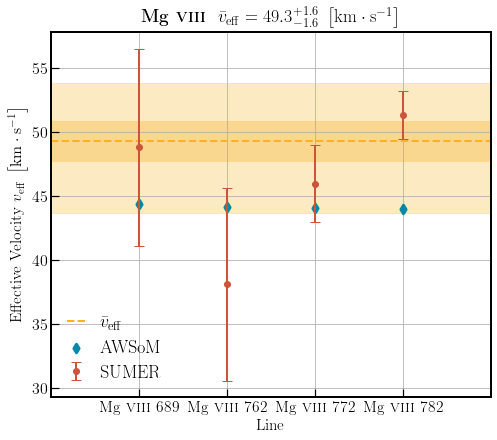

In [12]:
plot_eis_awsom_width(sumer_list_excel,"Mg",charge="viii",plot_mle=True)

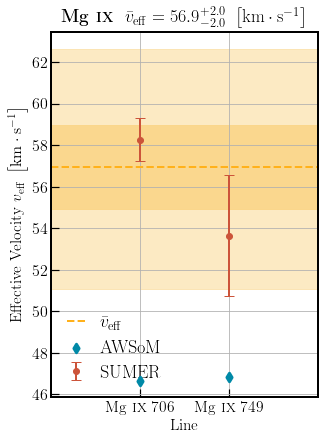

In [13]:
plot_eis_awsom_width(sumer_list_excel,"Mg",charge="ix",plot_mle=True)

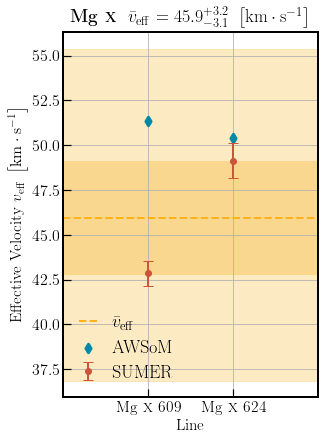

In [14]:
plot_eis_awsom_width(sumer_list_excel,"Mg",charge="x",plot_mle=True)

  ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
5  Fe        viii  7  55.85   5.8  697.155      697.156     0.281      0.02   

   fwhm_true  fwhm_awsom quality   eis_veff  awsom_veff  eis_veff_err  
5    0.19474       0.154       a  50.292494   39.771203      7.452966  


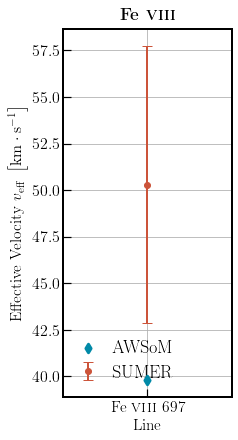

In [15]:
plot_eis_awsom_width(sumer_list_excel,"Fe",charge="viii",print_df=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
17  Fe           x  9  55.85   5.9  1028.04     1028.053     0.355      0.01   

    fwhm_true  fwhm_awsom quality   eis_veff  awsom_veff  eis_veff_err  
17    0.30064       0.253       a  52.651316   44.308086      2.067969  


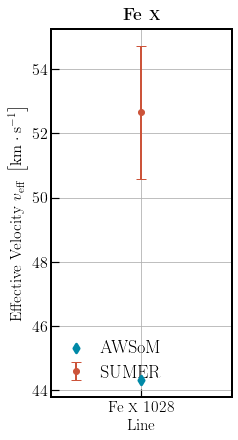

In [16]:
plot_eis_awsom_width(sumer_list_excel,"Fe",charge="x",print_df=True)

   ion charge_stat   Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
18  Fe          xi  10  55.85   6.0  1028.99     1028.955     0.322      0.03   

    fwhm_true  fwhm_awsom quality   eis_veff  awsom_veff  eis_veff_err  
18     0.2599       0.287       a  45.476588   50.218472      6.503579  


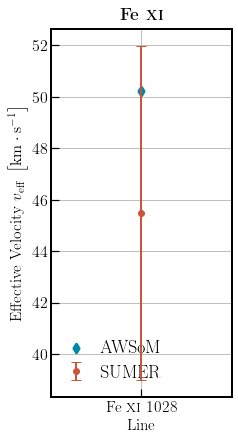

In [17]:
plot_eis_awsom_width(sumer_list_excel,ion="Fe",charge="xi",print_df=True)

  ion charge_stat  Z         A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
1  Na          ix  8  22.98977   5.9  681.759      681.719     0.308   

   fwhm_err  fwhm_true  fwhm_awsom quality   eis_veff  awsom_veff  \
1     0.005    0.23251       0.175       a  61.406482   46.217945   

   eis_veff_err  
1      1.749249  


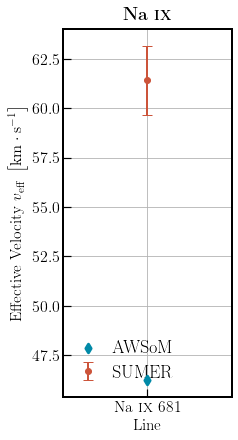

In [18]:
plot_eis_awsom_width(sumer_list_excel,"Na",charge="ix",print_df=True)

  ion charge_stat  Z       A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
8  Ar        viii  7  39.948   5.7  713.784      713.801     0.283      0.01   

   fwhm_true  fwhm_awsom quality   eis_veff  awsom_veff  eis_veff_err  
8    0.19754       0.166       a  49.825983   41.870574      3.613535  


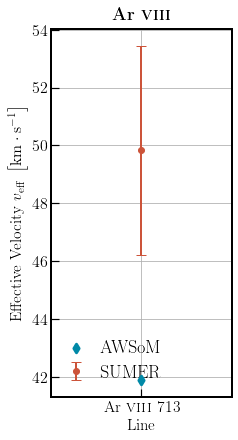

In [19]:
plot_eis_awsom_width(sumer_list_excel,"Ar","viii",print_df=True)

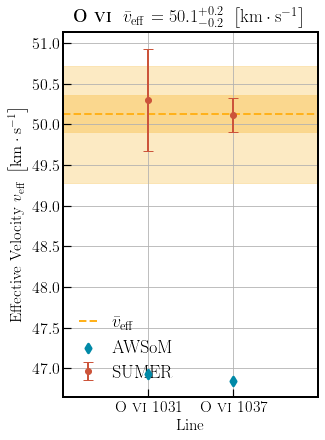

In [20]:
plot_eis_awsom_width(sumer_list_excel,"O","vi",plot_mle=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
14   S           x  9  32.06   6.0  776.242      776.373     0.358      0.05   

    fwhm_true  fwhm_awsom quality   eis_veff  awsom_veff  eis_veff_err  
14    0.29939       0.235       a  69.429629   54.497354     13.865109  


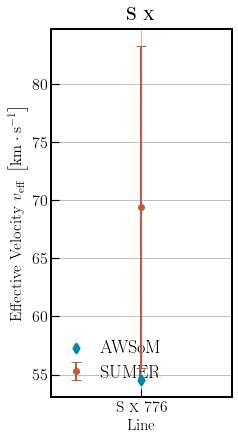

In [21]:
plot_eis_awsom_width(sumer_list_excel,"S","x",print_df=True)

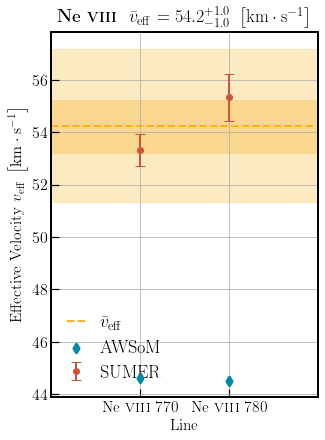

In [22]:
plot_eis_awsom_width(sumer_list_excel,"Ne","viii",plot_mle=True)

   ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
21  Si         vii  6  28.0855   5.8  1049.28     1049.153     0.352   

    fwhm_err  fwhm_true  fwhm_awsom quality   eis_veff  awsom_veff  \
21      0.02    0.29593       0.245       a  50.784145   42.044117   

    eis_veff_err  
21      4.082468  


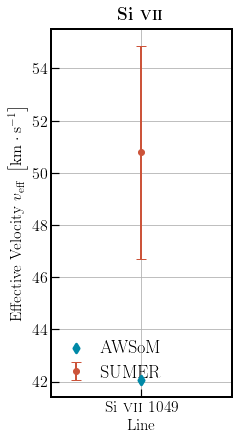

In [23]:
plot_eis_awsom_width(sumer_list_excel,"Si","vii",print_df=True)

  ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
4  Si          ix  8  28.0855   5.9  694.738      694.686     0.249      0.01   

   fwhm_true  fwhm_awsom quality   eis_veff  awsom_veff  eis_veff_err  
4     0.1418       0.185       a  36.750704   47.946969       4.55106  


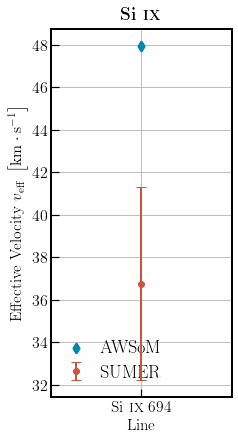

In [24]:
plot_eis_awsom_width(sumer_list_excel,"Si","ix",print_df=True)

  ion charge_stat  Z         A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
6  Al          ix  8  26.98154   5.9  703.592       703.73     0.256   

   fwhm_err  fwhm_true  fwhm_awsom quality   eis_veff  awsom_veff  \
6     0.086    0.15402       0.185       b  39.404791   47.330778   

   eis_veff_err  
6     36.570695  


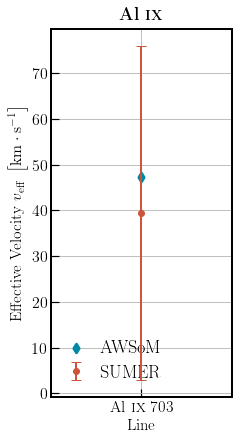

In [25]:
plot_eis_awsom_width(sumer_list_excel,"Al","ix",quality=["a","b"],print_df=True)

   ion charge_stat  Z         A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
22  Al         vii  6  26.98154   5.8  1053.86     1053.996     0.308   

    fwhm_err  fwhm_true  fwhm_awsom quality  eis_veff  awsom_veff  \
22      0.03    0.24488       0.247       a  41.83043   42.192569   

    eis_veff_err  
22      6.445516  


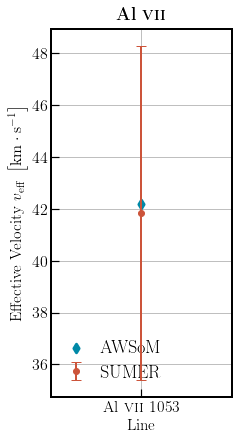

In [26]:
plot_eis_awsom_width(sumer_list_excel,"Al","vii",quality=["a","b"],print_df=True)

   ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
25  Si           x  9  28.0855   6.0   624.72      624.694     0.145   

    fwhm_err  fwhm_true  fwhm_awsom quality   eis_veff  awsom_veff  \
25      0.02    0.11184       0.262       b  32.233525   75.511298   

    eis_veff_err  
25      7.473284  


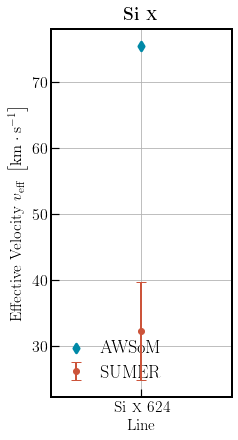

In [27]:
plot_eis_awsom_width(sumer_list_excel,"Si","x",quality=["a","b"],print_df=True)